# Introducción y contexto

El objetivo de este notebook es analizar la información de calidad del aire en la ciudad de Madrid. Para ellos se dispone de la información proporcionada por el [Portal de datos abiertos del Ayuntamiento de Madrid](https://datos.madrid.es/portal/site/egob). Para detalles de la extracción de los datos véase el notebook de recopilación y agrupación de los datos a partir de las diversas fuentes de información.

En este tipo de problemas, el objetivo básico de la predicción son las series temporales, que son un conjunto de observaciones registradas a lo largo del tiempo. Cuando trabajamos con series temporales, a menudo los que buscamos es "pronosticar" valores futuros basados en valores pasados. El *forecasting* es un tipo de predicción para series temporales. Antes de acometer los modelos para las series temporales usaremos un proceso de descomposición de series temporales para dividirlas en sus componentes.

El componente **tendencia** describe el comportamiento de las series temporales a largo plazo sin tener en cuenta la estacionalidad o los efectos cíclicos. Usando la tendencia podremos realizar declaraciones del tipo "la cantidad de partículas de NO<sup>2</sup> está dismunuyendo a lo largo de los años". El componente **estacionalidad** explica la sistemática y los movimientos relacionados con el calendario de una serie temporal. Por ejemplo, "la cantidad de partículas de NO<sup>2</sup> es bajo en verano y muy alto en invierto". Este patrón se repite anualmente, independientemente de que la cantidad real sea la misma en verano e invierno. Por último, el componente **cíclico** explica cualquier otra cosa inexplicable o irregular en las series temporales.

A lo largo del análisis iremos aplicacando diferentes modelos predictivos, en los que usaremos la información que vamos obteniendo de la descomposición de las series temporales (tendencia, estacionalidad y ciclos).

# Preparación de los datos

In [1]:
# Importación de las librerías necesarias
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
data_folder = {
    "estaciones": "datos/estaciones",
    "diarios": "datos/diarios",
    "horarios": "datos/horarios",
}

## Carga de datasets

En principio vamos a trabajar sobre los dataset de estaciones de medición y mediciones diarias, dejando para un análisis posterior el conjunto de mediciones horarias.

In [3]:
# Estaciones de medición
filename = os.path.join(data_folder["estaciones"], "estaciones.csv")
estaciones = pd.read_csv(filename, sep=";")

# Calidad del aire. Mediciones diarias
filename = os.path.join(data_folder["diarios"], "mediciones_diarias.csv")
calidad_d = pd.read_csv(filename, sep=";")


En primer lugar vamos a revisar el dataset de estaciones de medición. Por cada estación se dispone de los datos de dirección y ubicación exactas, así como algunos flags para indicar si se registran algunas de las magnitudes más relevantes.

In [4]:
estaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODIGO               24 non-null     int64  
 1   CODIGO_CORTO         24 non-null     int64  
 2   ESTACION             24 non-null     object 
 3   DIRECCION            24 non-null     object 
 4   LONGITUD_ETRS89      24 non-null     object 
 5   LATITUD_ETRS89       24 non-null     object 
 6   ALTITUD              24 non-null     int64  
 7   COD_TIPO             24 non-null     object 
 8   NOM_TIPO             24 non-null     object 
 9   NO2                  24 non-null     object 
 10  SO2                  5 non-null      object 
 11  CO                   5 non-null      object 
 12  PM10                 13 non-null     object 
 13  PM2_5                8 non-null      object 
 14  O3                   13 non-null     object 
 15  BTX                  6 non-null      objec

In [5]:
estaciones[["CODIGO", "DIRECCION", "NO2", "SO2", "CO", "PM10", "PM2_5", "O3", "BTX"]]

,CODIGO,DIRECCION,NO2,SO2,CO,PM10,PM2_5,O3,BTX
0,28079004,Plaza de España,X,X,X,NaN,NaN,NaN,NaN
1,28079008,Entre C/ Alcalá y C/ O’ Donell,X,X,X,X,X,X,X
2,28079011,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,X,NaN,NaN,NaN,NaN,NaN,X
3,28079016,C/ Arturo Soria esq. C/ Vizconde de los Asilos,X,NaN,NaN,NaN,NaN,X,NaN
4,28079017,C/ Juan Peñalver,X,NaN,NaN,NaN,NaN,X,NaN
5,28079018,C/ Farolillo - C/ Ervigio,X,NaN,X,X,NaN,X,X
6,28079024,Casa de Campo (Terminal del Teleférico),X,NaN,NaN,X,X,X,X
7,28079027,"C/ Júpiter, 21",X,NaN,NaN,NaN,NaN,X,NaN
8,28079035,Plaza del Carmen esq. Tres Cruces,X,X,X,NaN,NaN,X,NaN
9,28079036,Avda. Moratalaz esq. Camino de los Vinateros,X,X,NaN,X,NaN,NaN,NaN


El NO<sup>2</sup> (Dióxido de Nitrógeno) lo miden todas las estaciones por lo que sería una magnitud candidata a ser analizada con más detalle. Las magnitudes O3, PM10 y PM2,5 le siguen en orden. El **dióxido de nitrógeno (NO<sup>2</sup>)** es un contaminante atmosférico cuyas fuentes fundamentales son el tráfico rodado así como las emisiones de determinadas industrias y de calefacciones de carbón (en desuso actualmente). Sus niveles en la atmósfera están aumentando en los últimos años por la mayor utilización de gasolina diésel. Su presencia en el aire contribuye a la formación y modificación de otros contaminantes atmosféricos tales como el **ozono** y las **partículas en suspensión (PM10 y PM 2,5)**.

In [6]:
calidad_d["MAGNITUD"].value_counts()

7     4979
8     4979
12    4979
14    2812
10    2497
1     2326
6     2265
9     1130
20    1103
30    1103
35    1097
42     709
43     709
44     708
Name: MAGNITUD, dtype: int64

Vemos que, efectivamente, las magnitudes de las que se tienen más mediciones son el `NO`, `NO2`, `NOx`, `O3` y Partículas `PM10`.

Vamos a estudiar las mediciones de NO<sup>2</sup>. Por tanto, vamos a seleccionar únicamente los registros correspondientes a la columna `NO2`.

In [7]:
df_no2 = calidad_d[calidad_d["MAGNITUD"] == 7].copy()
df_no2.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
14,28,79,4,7,28079004_7_8,2022,3,0.0,N,0.0,...,0.0,N,11.0,V,5.0,V,5.0,V,3.0,V
15,28,79,4,7,28079004_7_8,2022,4,4.0,V,3.0,...,3.0,V,14.0,V,5.0,V,13.0,V,0.0,N
16,28,79,4,7,28079004_7_8,2022,5,9.0,V,2.0,...,4.0,V,3.0,V,5.0,V,2.0,V,9.0,V
17,28,79,4,7,28079004_7_8,2022,6,4.0,V,4.0,...,2.0,V,3.0,V,7.0,V,3.0,V,0.0,N
18,28,79,4,7,28079004_7_8,2022,7,3.0,V,2.0,...,2.0,V,6.0,V,6.0,V,2.0,V,4.0,V


¿Cuántos registros de NO<sup>2</sup> existen en el dataset?

In [8]:
df_no2.shape[0]

4979

Dado que por cada día existen varios registros de mediciones, las correspondientes a cada una de las estaciones de medición, vamos a calcular la media diaria de todas ellas, de forma que exista un registro único por cada día. Hay que tener en cuenta, que hay un atributo que indica si la medición es válida. Dicha colulmna tiene el formato V99, siendo 99 el día del mes.

In [9]:
# Calculamos la media de las medición del dia 1 del mes, únicamente si son válidas (V<dia_correspondiente> = "S")
df_no2[df_no2["V01"]=="V"].groupby(by=["ANO", "MES"], as_index=False)["D01"].mean()

,ANO,MES,D01
0,2001,1,47.583333
1,2001,2,126.750000
2,2001,3,84.583333
3,2001,4,20.636364
4,2001,5,9.727273
...,...,...,...
256,2022,5,3.333333
257,2022,6,5.250000
258,2022,7,2.478261
259,2022,8,2.956522


Una vez que hemos validado que la consulta de agrupación es la correcta, vamos a crear un dataframe que contenga por cada día, la media de las mediciones de todas las estaciones, siempre y cuando tenga el flag de válido (`V<día> = "S"`)

In [10]:
fechas = []
mediciones = []

for i in range(1, 32):

    n_day = f"{i:02d}"
    dato_dia = f"D{n_day}"      # columna de la medición del día del mes
    validez_dia = f"V{n_day}"   # columna de validez de la medición del día del mes

    # Calculamos la media de las medición de ese día, únicamente si son válidas (V<dia_correspondiente> = "S")
    group_periodo = df_no2[df_no2[validez_dia]=="V"].groupby(by=["ANO", "MES"], as_index=False)[dato_dia].mean()
    for row in range(len(group_periodo)):
        fecha_medicion = str(int(group_periodo.iloc[row]['ANO'])) + "-" + str(int(group_periodo.iloc[row]['MES'])) + "-" + str(i)
        fechas.append(datetime.strptime(fecha_medicion, '%Y-%m-%d'))
        mediciones.append(group_periodo.iloc[row][dato_dia])

datos = {
    "fecha": fechas,
    "medicion": mediciones
}

df = pd.DataFrame(datos)

# Generamos el archivo csv con los datos de las mediciones agrupadas por día
df.to_csv("diario_no2.cvs", sep=";", index=False)

# EDA

Bien, ya tenemos listo el archivo .csv, así que vamos a cargarlo, estableciendo como índice el campo `fecha`, que es lo más idóneo para datasets de series temporales, ya que optimiza determinadas operaciones y nos brinda la posibilidad de utilizar métodos específicos de tratamiento de fechas.

In [11]:
diario_no2 = pd.read_csv("diario_no2.cvs", sep=";", parse_dates=["fecha"])
diario_no2.set_index("fecha", inplace=True)
diario_no2.sort_index(inplace=True)

In [12]:
diario_no2.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24',
               '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28',
               '2022-09-29', '2022-09-30'],
              dtype='datetime64[ns]', name='fecha', length=7942, freq=None)

In [13]:
diario_no2.head()

,medicion
fecha,
2001-01-01,47.583333
2001-01-02,39.000000
2001-01-03,53.833333
2001-01-04,51.833333
2001-01-05,80.083333


In [14]:
diario_no2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7942 entries, 2001-01-01 to 2022-09-30
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   medicion  7942 non-null   float64
dtypes: float64(1)
memory usage: 124.1 KB


Bien, no existen nulos. Vamos a comprobar cómo se distribuyen las mediciones y a obtener algunos estadísticos básicos del dataset.

In [15]:
diario_no2.describe()

,medicion
count,7942.000000
mean,28.439038
std,35.507958
min,1.375000
25%,7.583333
50%,15.250000
75%,33.572917
max,379.300000


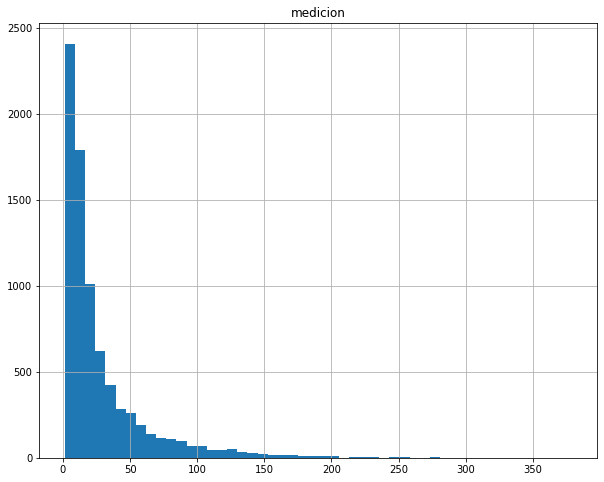

In [16]:
diario_no2.hist(bins=50, figsize=(10,8));

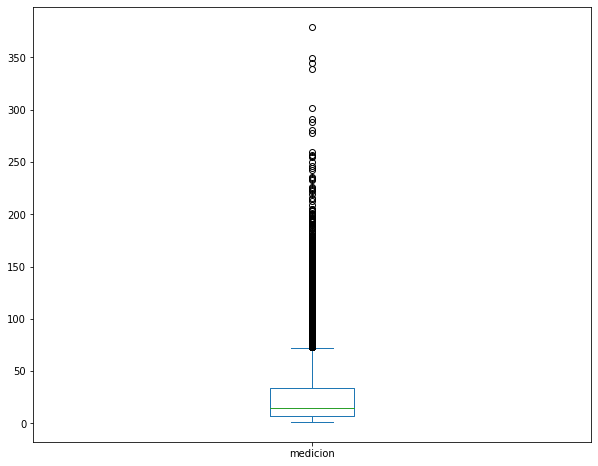

In [17]:
diario_no2.plot.box(figsize=(10,8));

Los dos gráficos anteriores nos muestran cómo se distribuyen los valores de las mediciones de NO<sup>2</sup>. El 75% de las mediciones se encuentran entre 1.37 y 33.57, existiendo muchos valores atípicos y con un máximo de 379.

Vamos a visualizar cómo se distribuye la media anual:

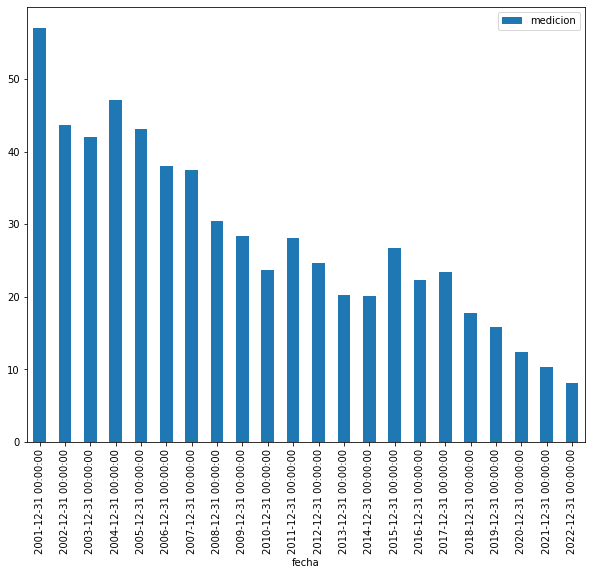

In [18]:
# Medición media anual
diario_no2.resample("Y").mean().plot.bar(figsize=(10,8));


## Variables de paso de tiempo (*time-step*)

Empezamos nuestro análisis de los principales componentes de las series temporales. Existen dos tipo de features únicas y distintivas de las series temporales: las variables de paso de tiempo (*time-step*) y las variables de *lag*. Las features de paso de tiempo son variables que se pueden derivar directamente del índice de tiempo. La feature de paso de tiempo más básica es la dummy (*time dummy*), que cuenta el número de pasos de tiempo en las series desde el principio al final.

Vamos a crear una variable de paso de tiempo (*time-step*).

In [19]:
diario_no2["time"] = np.arange(len(diario_no2.index))

diario_no2.head()

,medicion,time
fecha,,
2001-01-01,47.583333,0
2001-01-02,39.000000,1
2001-01-03,53.833333,2
2001-01-04,51.833333,3
2001-01-05,80.083333,4


Vamos a usar el algoritmo de regresión lineal para construir nuestro modelo predictivo.

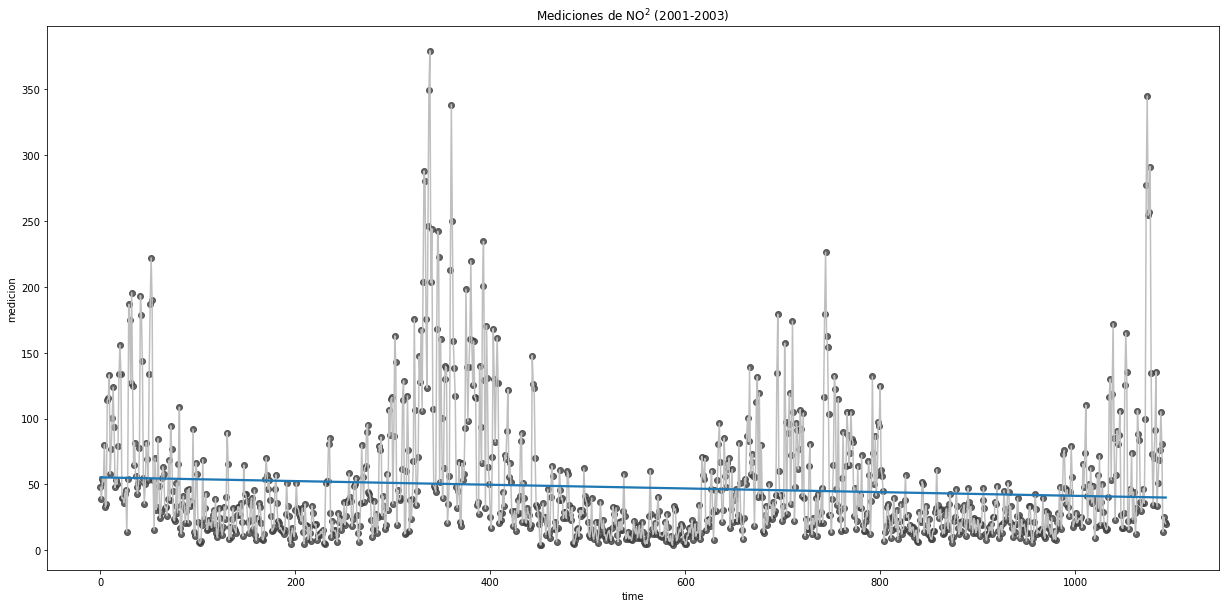

In [20]:
# Mediciones realizadas hasta el año 2003
df = diario_no2[diario_no2.index.year.isin([2001, 2002, 2003])]

fig, ax = plt.subplots(figsize=(21, 10))
ax.plot("time", "medicion", data=df, color="0.75")
ax = sns.regplot(x="time", y="medicion", data=df, ci=None,
                 scatter_kws=dict(color="0.25"))
ax.set_title("Mediciones de NO$^2$ (2001-2003)");

Las features de paso de tiempo nos permiten modelar la dependencia del tiempo. Una serie es dependiente del tiempo si sus valores se pueden predecir desde el momento en que ocurrieron. En las series de nuestro ejemplo, podemos predecir que las mediciones de NO<sup>2</sup> al principio y final del año (otoño-invierno) son generalmente más altas que las mediciones realizadas durante los meses de mitad de año (primavera-verano).

## Variables *lag*

Vamos a creanos una variable *lag*. Las variable de lag nos permiten modelar la dependencia en serie o serial.

In [21]:
diario_no2["Lag_1"] = diario_no2["medicion"].shift(1)
diario_no2.head()

,medicion,time,Lag_1
fecha,,,
2001-01-01,47.583333,0,NaN
2001-01-02,39.000000,1,47.583333
2001-01-03,53.833333,2,39.000000
2001-01-04,51.833333,3,53.833333
2001-01-05,80.083333,4,51.833333


Las variables de lag nos permiten dibujar gráficas donde cada observación en una serie se dibuja contra la observación anterior.

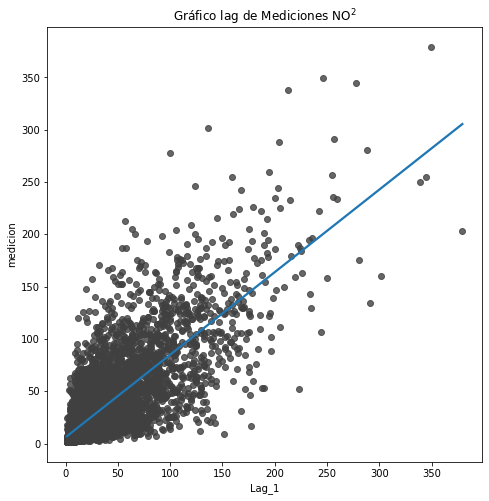

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.regplot(x="Lag_1", y="medicion", data=diario_no2, ci=None,
                 scatter_kws=dict(color="0.25"))
ax.set_aspect("equal")
ax.set_title("Gráfico lag de Mediciones NO$^2$");

Podemos ver en el gráfico de lag que las mediciones de un día (`medicion`) están correlacionadas con las mediciones del día anterior (`Lag_1`). Cuando vemos una relación como ésta sabemos que una variable de lag será útil.

Una serie temporal tiene dependencia serial cuando una observación se puede predecir a partir de las observaciones previas. En nuestro ejemplo, podemos predecir que mediciones altas en un día, generalmente significan mediciones altas en el siguiente día.

## Tendencias

La tendencia de una serie temporal representa un cambio persistente a largo plazo en la media de la serie. La tendencia es la parte más lenta del movimiento de una serie, la parte que representa la mayor escala de tiempo de importancia.

Para ver qué tipo de tendencia podría tener una serie temporal podemos usar un **gráfico de média móvil**. Para calcular una media móvil de una serie temporal, calculamos la media de los valores dentro de una ventana deslizante de un ancho definido. Cada punto del gráfico representa la media de todos los valores de la serie que se encuentran dentro de la ventada de cada lado. La idea es suavizar cualquier fluctuación a corto plazo en la serie para que solo permanezcan los cambios a largo plazo.

Vamos a cargar de nuevo el dataset, estableciendo el campo `fecha` como índice y declarándolo explícitamente con una peridicidad (D)iaria.

In [23]:
diario_no2 = pd.read_csv("diario_no2.cvs", sep=";", parse_dates=["fecha"])
diario_no2.set_index("fecha", inplace=True)
diario_no2.index.to_period("D")
diario_no2.sort_index(inplace=True)

In [24]:
# Valores por defecto de los gráficos
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(15, 7))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

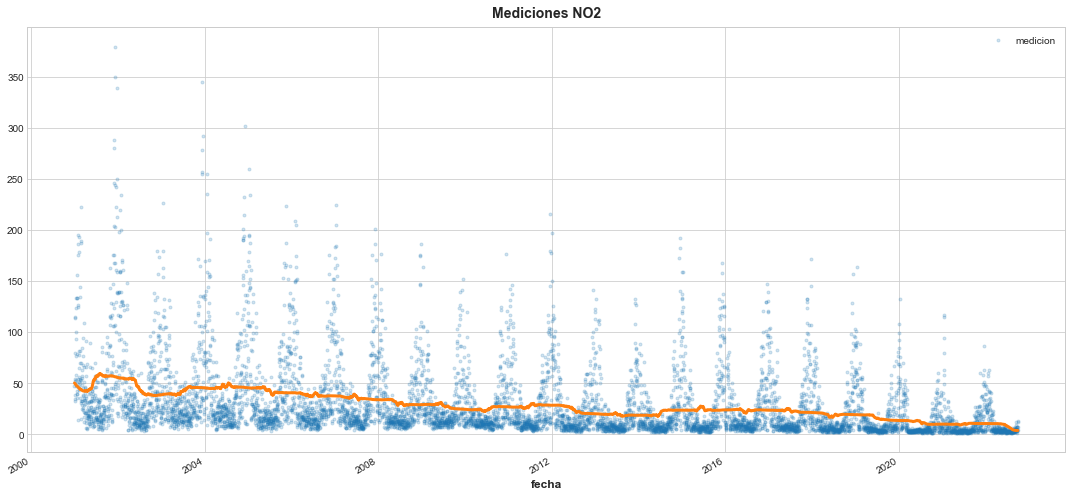

In [25]:
moving_average = diario_no2[["medicion"]].rolling(
    window=365,       # ventana de 365 días
    center=True,      # pone la media en el dentro de la ventana
    min_periods=183,  # selecciona la mitad del tamaño de la ventana
).mean()              # calcula la media (también podría hacerse la mediana, desviación, mínimo, máximo, ...)

ax = diario_no2[["medicion"]].plot(style=".", alpha=0.2)
moving_average.plot(
    ax=ax, linewidth=3, title="Mediciones NO2", legend=False,
);

Especificar un parámetro `alpha` en el gráfico nos permite distinguir dónde existe mayor concentración de mediciones. 

Comprobamos que la **tendencia** parece ser lineal.

Aunque podemos crear directamente en Pandas nuestra *time dummy*, usaremos una función de la librería `statsmodels` llamada `DeterministicProcess`.

In [26]:
dp = DeterministicProcess(
    index=diario_no2.index,  # fechas de los datos de entrenamiento
    constant=True,       # variable dummy para el bias (y_intercept)
    order=1,             # la time dummy (tendencia)
    drop=True,           # elimina términos si es necesario para evitar colinearidad
)
# crea features para las fechas dadas en el argumento `index`
X = dp.in_sample()

X.head()

,const,trend
fecha,,
2001-01-01,1.0,1.0
2001-01-02,1.0,2.0
2001-01-03,1.0,3.0
2001-01-04,1.0,4.0
2001-01-05,1.0,5.0


Entrenamos un modelo de regresión lineal:

In [27]:
y = diario_no2["medicion"]  # objetivo

# intercept es lo mismo que la variable `const` de DeterministicProcess.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

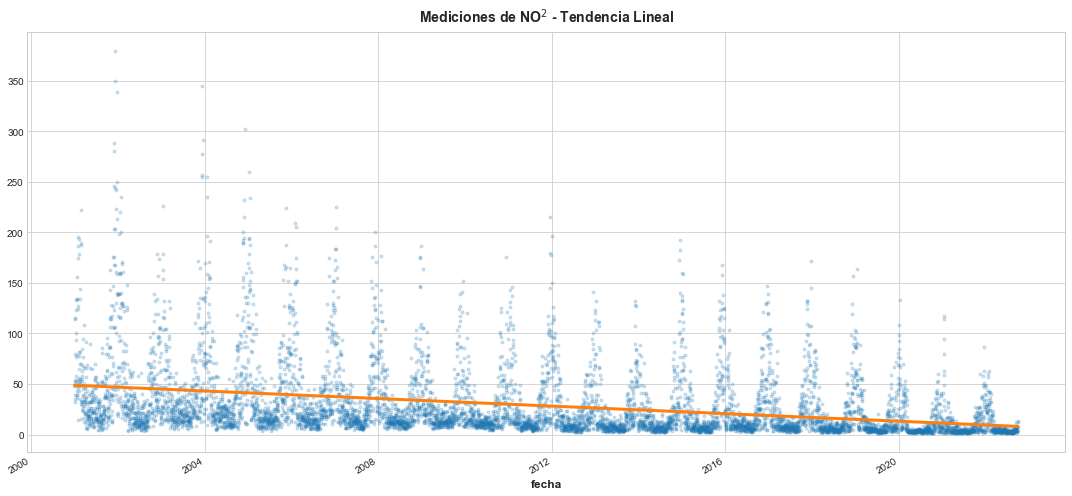

In [28]:
ax = diario_no2["medicion"].plot(style=".", alpha=0.2, title="Mediciones de NO$^2$ - Tendencia Lineal")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

La tendencia descubierta por nuestro modelo de regresión lineal es casi idéntica a la gráfica de media móvil, lo que sugiere que una tendencia lineal fue la decisión correcta en este caso.

Vamos a mostrar las principales métricas de nuestro modelo predictivo

In [29]:
def mostrar_metricas(y, y_pred):
    print(f"Principales métricas")
    print("====================")
    print(f"MAE: {mean_absolute_error(y, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y, y_pred):.3f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.3f}")
    print(f"R2: {r2_score(y, y_pred):.3f}")

In [30]:
mostrar_metricas(y, y_pred)

Principales métricas
MAE: 21.928
MSE: 1122.930
RMSE: 33.510
R2: 0.109


Como recordatorio, R<sup>2</sup> se interpreta como la proporción de la varianza total que se explica por el modelo. Nuestro modelo sólo sería capaz de explicar el 10,9%  de la varianza total. Por tanto, tenemos que seguir mejorando nuestro modelo.

## Estacionalidad

Se dice que una serie temporal exhibe estacionalidad siempre que haya un cambio regular y periodico en la media de la serie. Veremos que hay dos tipos de variables que modelan la estacionalidad. El primer tipo, los indicadores, es mejor para una estacionalidad con pocas observaciones, como la estacionalidad semanal de observaciones diarias. El segundo tipo, variables Fourier, es mejor para una estacionalidad con muchas observaciones, como la estacionalidad anual de observaciones diarias.

Los indicadores estacionales son features binarias que representan diferencias estacionales en el nivel de una serie temporal. Los indicadores estacionales son lo que obtenemos si tratamos un periodo estacional como una variable categórica y le aplicamos codificación one-hot.

Las variable Fourier son más apropiadas para grandes estacionalidades en muchas observaciones, donde los indicadores serían impracticables. En lugar de crear una variable para cada fecha, las features Fourier intentar capturar la forma global de la curva estacional con solo unas pocas features. La idea es incluir en nuestros datos de entrenamiento curvas periodicas que tengan las mismas frecuencias que la estación que estamos intentando modelar. Las curvas que utilizamos son las de las funciones seno y coseno. Este es el tipo de variables que vamos a utilizar para nuestro análisis.

Podemos usar una **gráfica estacional** para descubrir patrones estacionales.

In [31]:
diario_no2 = pd.read_csv("diario_no2.cvs", sep=";", parse_dates=["fecha"])
diario_no2.set_index("fecha", inplace=True)
diario_no2 = diario_no2.asfreq('D')
diario_no2.sort_index(inplace=True)

Comprobamos si nos falta algún día para el que no se hayan recogido medidas:

In [32]:
diario_no2[diario_no2["medicion"].isnull()]

,medicion
fecha,
2003-07-05,NaN


Sí, el día 5 de julio de 2003 no se recogieron medidas de NO2. La medición del registro de ese día la rellenamos con 0.

In [33]:
diario_no2 = diario_no2.fillna(0.0)

 A continuación, nos creamos una serie de funciones que nos agilicen el análisis y el trabajo posterior. En primer lugar, nos creamos una función para derivar un conjunto de features Fourier a partir del índice de una serie temporal:

In [34]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

Creamos una función para dibujar las gráficas estacionales:

In [35]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Gráfico estacional ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

Y otra función para dibujar el periodograma:

In [36]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Anual (1)",
            "Semestral (2)",
            "Trimestral (4)",
            "Bimensual (6)",
            "Mensual (12)",
            "Quincenal (26)",
            "Semanal (52)",
            "1/2 semanal (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Varianza")
    ax.set_title("Periodograma")
    return ax

In [37]:
# Establece valores por defecto de Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

Echemos un vistazo al gráfico estacional durante una semana y durante un año.

In [38]:
X = diario_no2.copy()

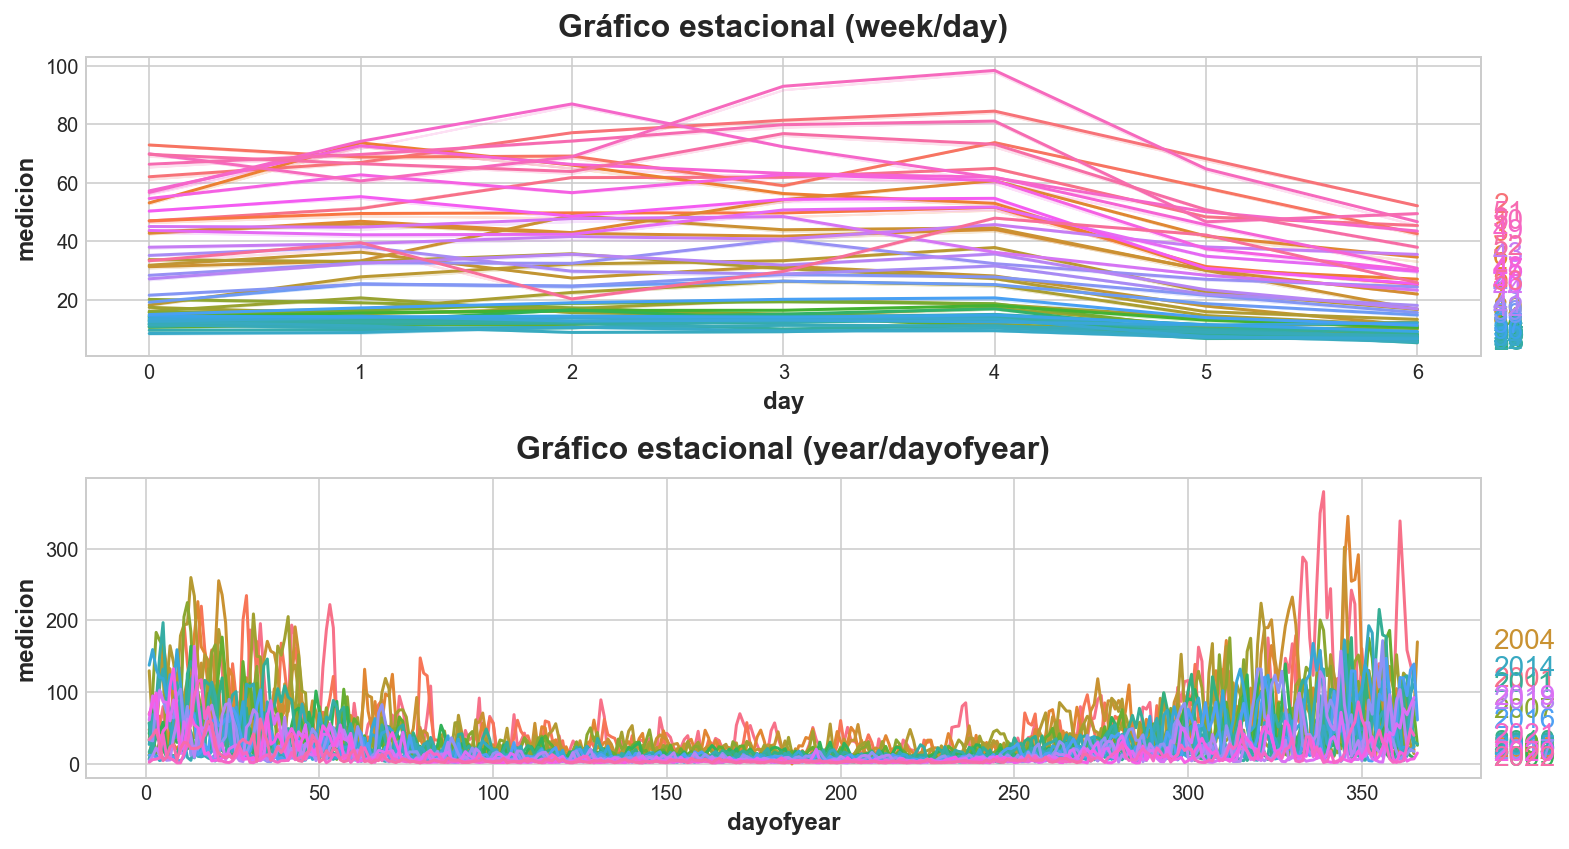

In [39]:
# días dentro de una semana
X["day"] = X.index.dayofweek  # eje x (freq)
X["week"] = X.index.week  # periodo estacional (period)

# días dentro de un año
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="medicion", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="medicion", period="year", freq="dayofyear", ax=ax1);

El gráfico estacional no parece mostrar ningún patrón semanal/diario. Sin embargo, sí ocurre en el gráfico estacional anual, donde tanto al principio y al final de año se producen valores más elevados, mientras que en los meses centrales del año las mediciones son menores.

Veamos ahora el periodograma:

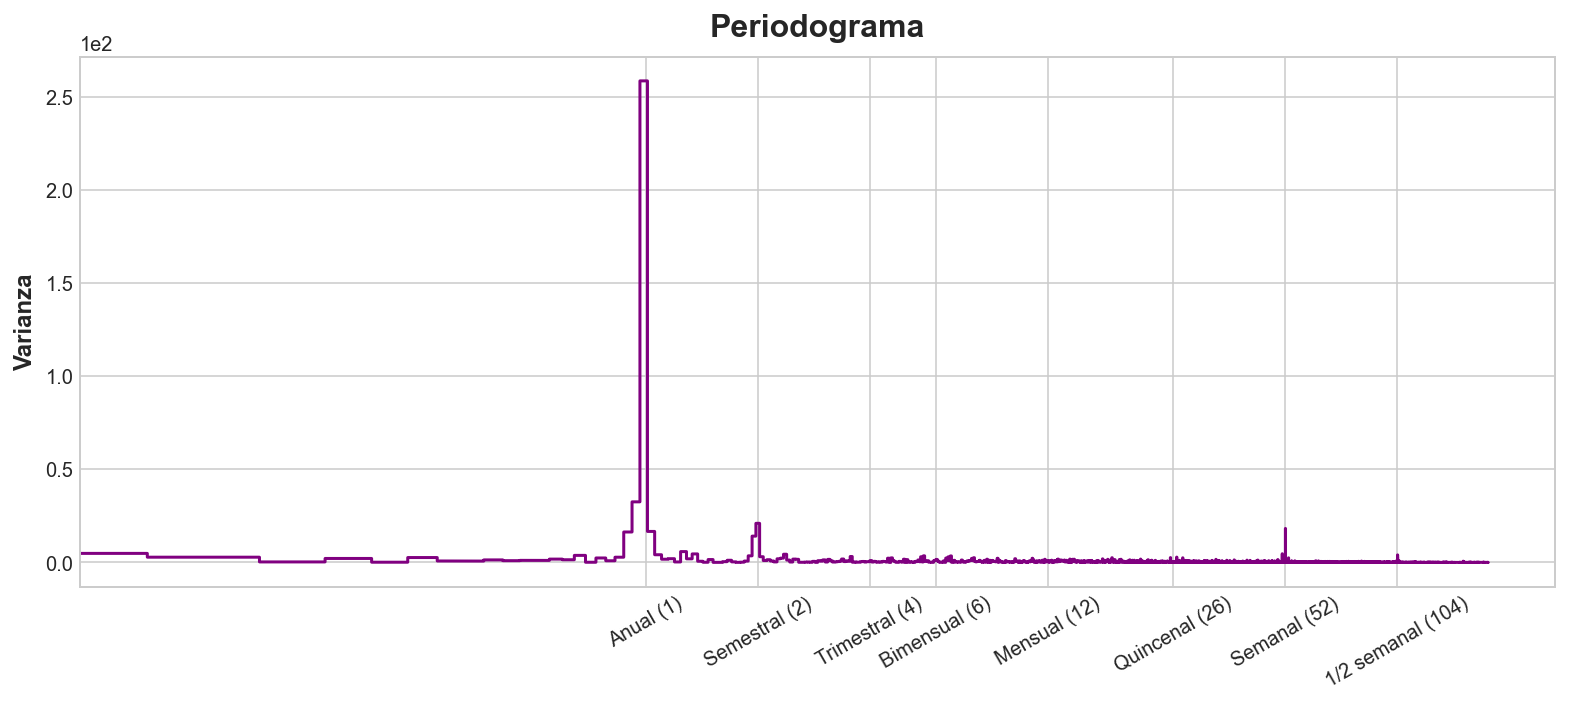

In [40]:
plot_periodogram(diario_no2["medicion"]);

El periodograma también confirma la existencia de estacionalidad anuales, así como la posible existencia de un componente semestral. 

Crearemos nuestras features estacionales usando DeterministicProcess, la misma utilidad usada para crear la features de tendencia.

In [41]:
fourier = CalendarFourier(freq="A", order=10)  # 10 pares seno/coseno para estacionalidad "A"nual

dp = DeterministicProcess(
    index=diario_no2.index,
    constant=True,               # feature dummy para bias (y-intercept)
    order=1,                     # tendencia (orden 1 significa lineal)
    seasonal=True,               # estacionalidad semanal (indicadores)
    additional_terms=[fourier],  # estacionalidad anual (fourier)
    drop=True,                   # eliminamos términos para evitar colinealidad
)

X = dp.in_sample()  # crear features para fecha en tunnel.index

In [42]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2001-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2001-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2001-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2001-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


Con nuestro conjunto de features creado, estamos listos para entrenar el modelo y hacer predicciones. Añadiremos un pronóstico de 365 días para ver cómo extrapola nuestro modelo más allá de los datos de entrenamiento.

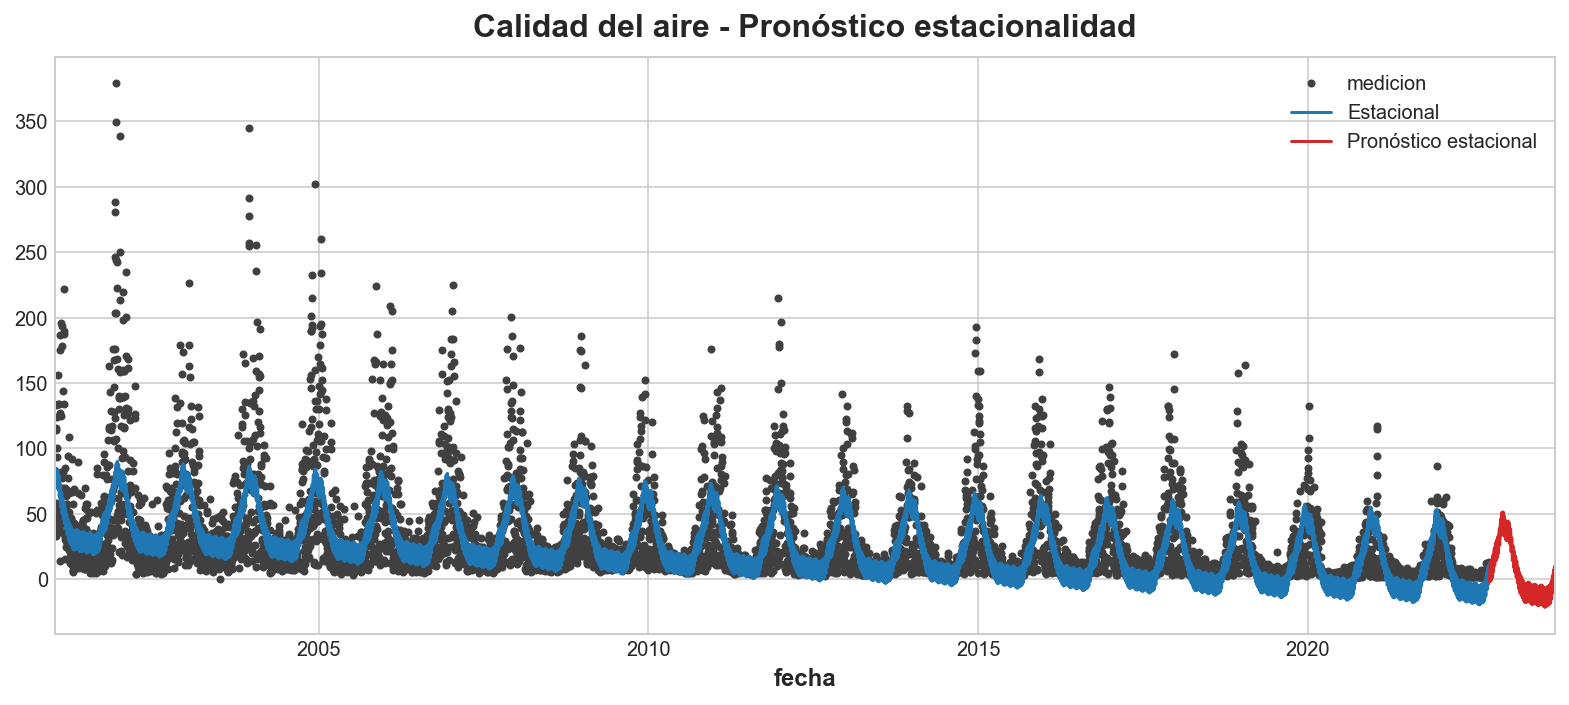

In [43]:
y = diario_no2["medicion"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=365)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Calidad del aire - Pronóstico estacionalidad")
ax = y_pred.plot(ax=ax, label="Estacional")
ax = y_fore.plot(ax=ax, label="Pronóstico estacional", color='C3')
_ = ax.legend()

In [44]:
mostrar_metricas(y, y_pred)

Principales métricas
MAE: 17.210
MSE: 742.799
RMSE: 27.254
R2: 0.411


Respecto al anterior modelo de regresión lineal, este modelo mejora en todas las métricas, incluido el indicador R<sup>2</sup>. En este caso, el modelo es capaz de explicar el 41% de la varianza total. De la visualización del diagrama anterior observamos cómo nuestro modelo logra captar las fluctuaciones estacionales en las mediciones de NO<sup>2</sup>, pero no consigue capturar los picos.

### Comprobar la estacionalidad restante

Eliminar de una serie su tendencia o estacionalidad se denomina “*detrending*” o “desestacionalizar” la serie. Observemos el periodograma de la serie desestacionalizada.

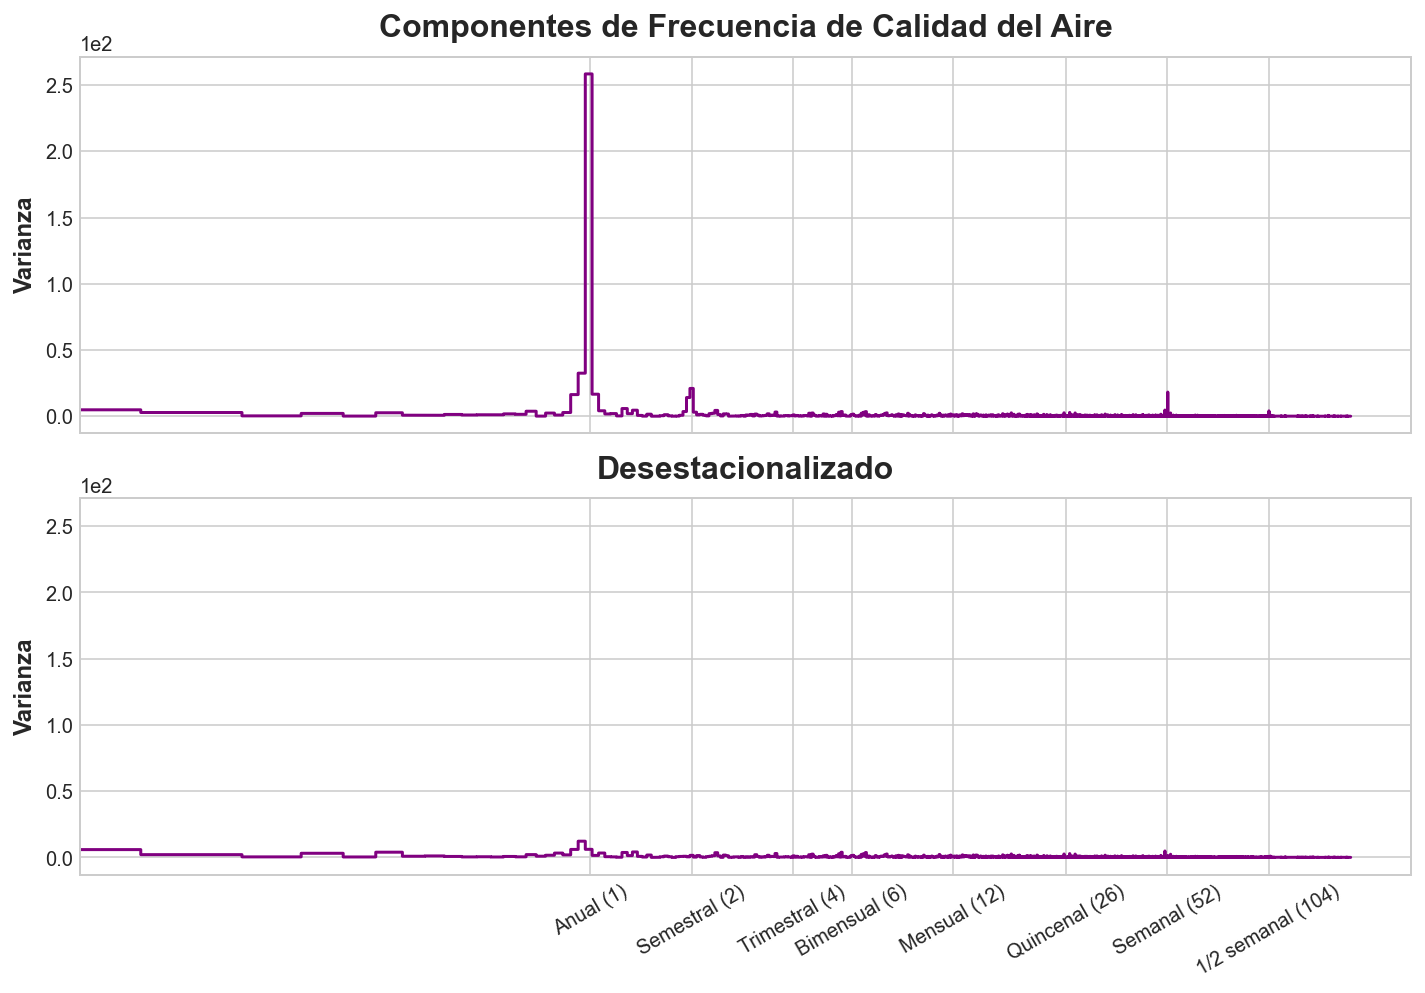

In [45]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Componentes de Frecuencia de Calidad del Aire")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Desestacionalizado");

El periodograma de la serie desestacionalizada carece de valores grandes. Al compararlo con el periodograma de la serie original podemos ver que nuestro modelo fue capaz de capturar la variación estacional en el dataset.

## Ciclos

Hemos visto las propiedades de las series temporales que se modelan más fácilmente como propiedades *dependientes del tiempo*, es decir, con features que podemos derivar directamente del índice del tiempo. Sin embargo, algunas propiedades de las series temporales solo se pueden modelar como propiedades *dependientes serialmente*, es decir, usando como features valores pasados de la serie objetivo.

Una forma especialmente común en la que se manifiesta la dependencia serial es en los ciclos. Los ciclos son patrones de crecimiento y decrecimiento en una serie temporal asociados a cómo los valores de una serie en un momento dependen de los valores del momento anterior, pero no necesariamente del paso de tiempo en sí.

Lo que distingue el comportamiento cíclico de la estacionalidad es que los ciclos no son necesariamente dependientes del tiempo, como lo es la estacionalidad. Lo que sucede en un ciclo tiene menos que ver con la fecha en particular de ocurrencia y más con lo que sucedió en el pasado reciente.

Para investigar la posible dependencia serial (como ciclos) en una serie temporal, necesitamos crear copias “demoradas” (*lagged*) de la serie. Demorar o *lagging* una serie temporal significa deslizar/desplazar sus valores hacia adelante uno o más pasos de tiempo, o de forma equivalente, desplazar los tiempos de su índice hacia atrás uno o más pasos de tiempo. En cualquier caso, el efecto es que las observaciones en las serie lagged parecen haber sucedido más tarde en el tiempo.

Igual que anteriormente, nos creamos una serie de funciones que nos agilicen el análisis y el trabajo posterior.

In [46]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

Creamos una función para dibujar los gráficos de lag:

In [47]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [48]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [49]:
diario_no2 = pd.read_csv("diario_no2.cvs", sep=";", parse_dates=["fecha"])
diario_no2.set_index("fecha", inplace=True)
diario_no2 = diario_no2.asfreq('D')
diario_no2.sort_index(inplace=True)

In [50]:
diario_no2 = diario_no2.fillna(0.0)

### Gráfico de lag

Un gráfico de lag de una serie temporal muestra sus valores dibujados contra sus lag’s. La dependencia serial en una serie temporal a menudo se hace evidente mirando un gráfico de lag.

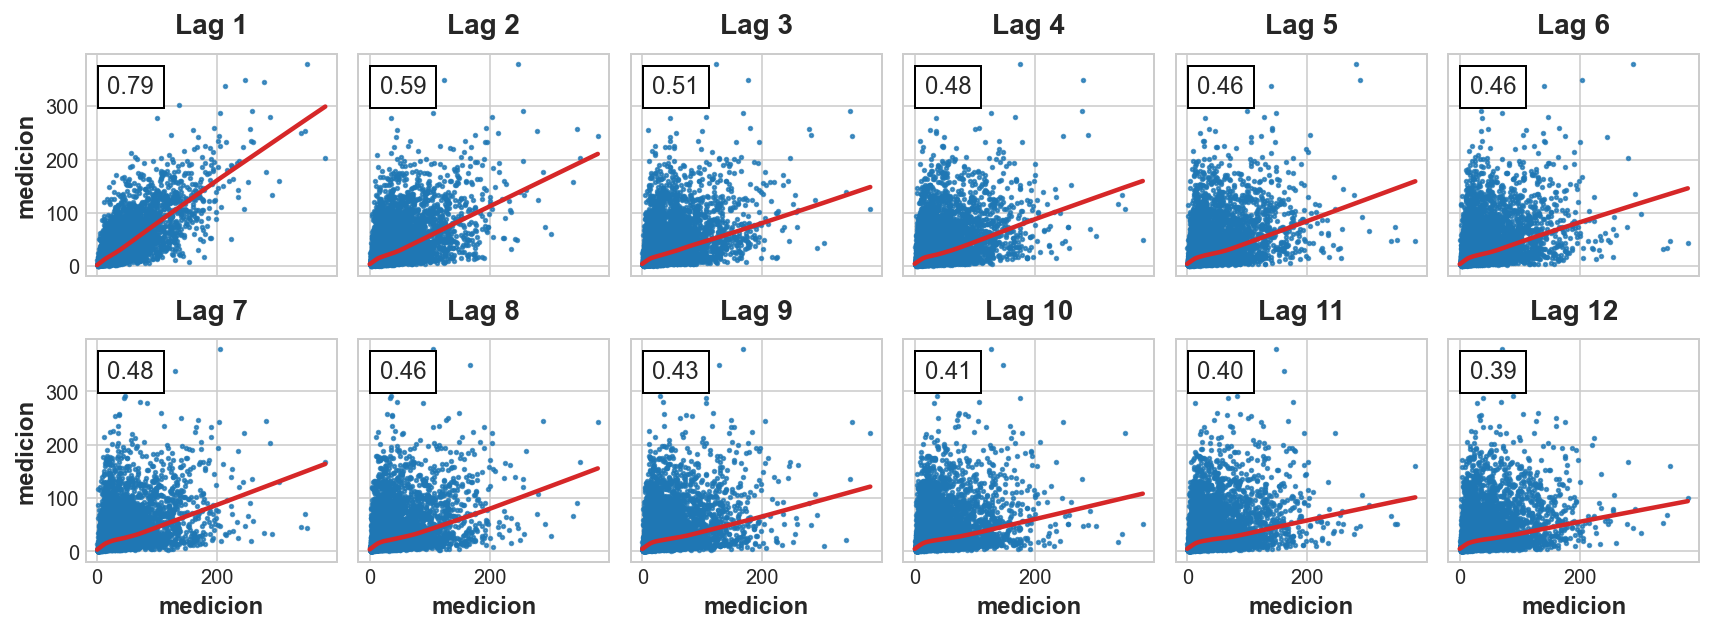

In [51]:
_ = plot_lags(diario_no2["medicion"], lags=12, nrows=2)


La medida más comúnmente usada de dependencia serial es la **autocorrelación**, que es simplemente la correlación que una serie temporal tiene con uno de sus lag’s. En nuestro caso, la medición de NO<sup>2</sup> tiene una autocorrelación de 0.79 en el lag 1, de 0.59 en el lag 2, y así sucesivamente.

### Correlograma

Generalmente, cuando elegimos lag’s para usarlos como features, no será útil incluir cada lag con una gran autocorrelación. La autocorrelación parcial nos dice la correlación de un lag teniendo en cuenta todos los lag’s previos. Por así decirlo, la cantidad de correlación “nueva” que aporta el lag. Dibujar la autocorrelación parcial puede ayudar a elegir qué feature de lag usar.

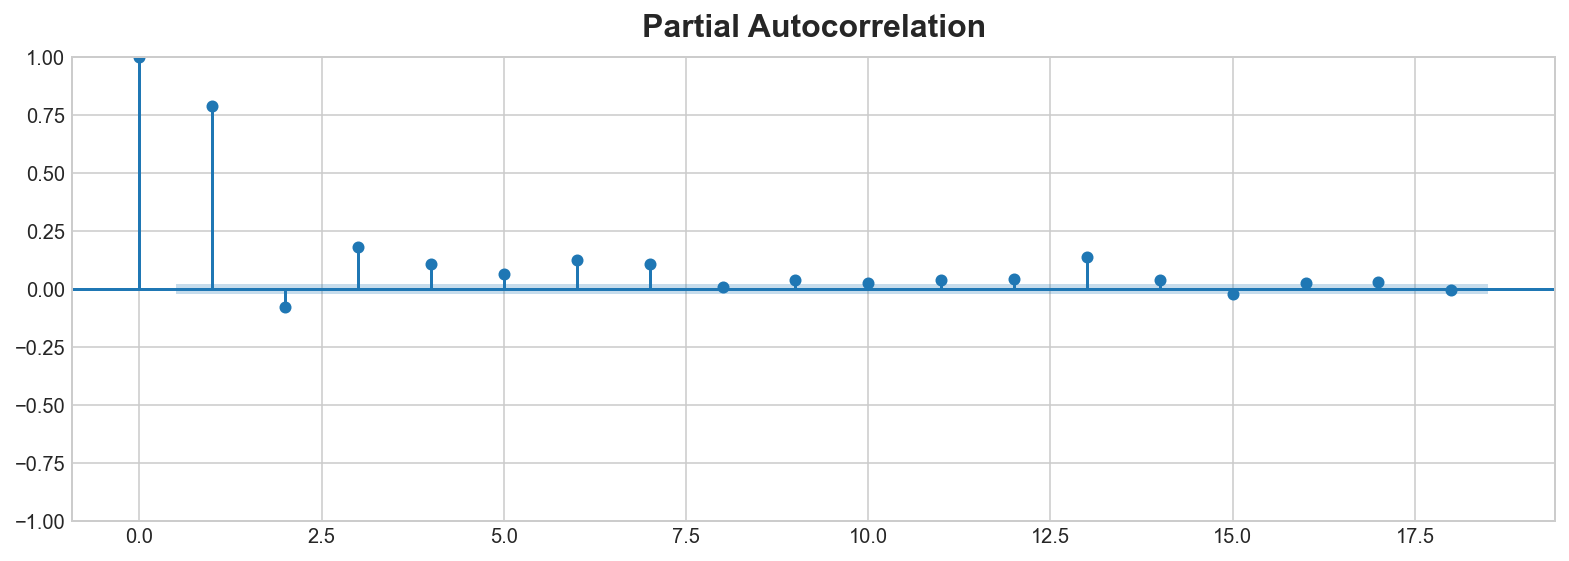

In [52]:

_ = plot_pacf(diario_no2["medicion"], lags=18, method="ywm")

El diagrama anterior se denomina correlograma y muestra las autocorrelaciones parciales de las mediciones de NO<sup>2</sup> hasta el lag 12 con intervarlos de confianza del 95% de no correlación. En la siguiente figura, el lag 1 hasta el lag 7 caen fuera del intervalo de “no correlación” (en azul), por lo que podríamos usar estos 7 lag’s como features.

El correlograma sugiere que la dependencia puede ser capturada usando lag 1, 2, 3, 4, 5, 6 y 7. En Pandas podemos crear features lag con el método shift. En este caso, rellenaremos los datos faltantes que genera el lagging con 0.0.

Con este conjunto de features creado, estamos listos para entrenar un nuevo modelo y hacer predicciones. Dado el volumen de los datos vamos a utilizar el último 5% de las mediciones para validar nuestras 
predicciones.

In [53]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [54]:
X = make_lags(diario_no2["medicion"], lags=7)
X = X.fillna(0.0)

X.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7
fecha,,,,,,,
2001-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2001-01-02,47.583333,0.000000,0.000000,0.000000,0.0,0.0,0.0
2001-01-03,39.000000,47.583333,0.000000,0.000000,0.0,0.0,0.0
2001-01-04,53.833333,39.000000,47.583333,0.000000,0.0,0.0,0.0
2001-01-05,51.833333,53.833333,39.000000,47.583333,0.0,0.0,0.0


In [55]:
# Crea la serie objetivo y divide los datos
y = diario_no2["medicion"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

# Entrena y predice
model = LinearRegression()  # `fit_intercept=True` dado que no usamos DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [56]:
#mostrar_metricas(y_train, y_pred)
mostrar_metricas(y_test, y_fore)

Principales métricas
MAE: 5.874
MSE: 75.155
RMSE: 8.669
R2: 0.517


Bien, el hecho de usar estas variables lag nos ha permitido mejorar nuestro modelo predicivo, respecto al anterior. En este caso, el modelo es capaz de explicar el 65% de la varianza total.

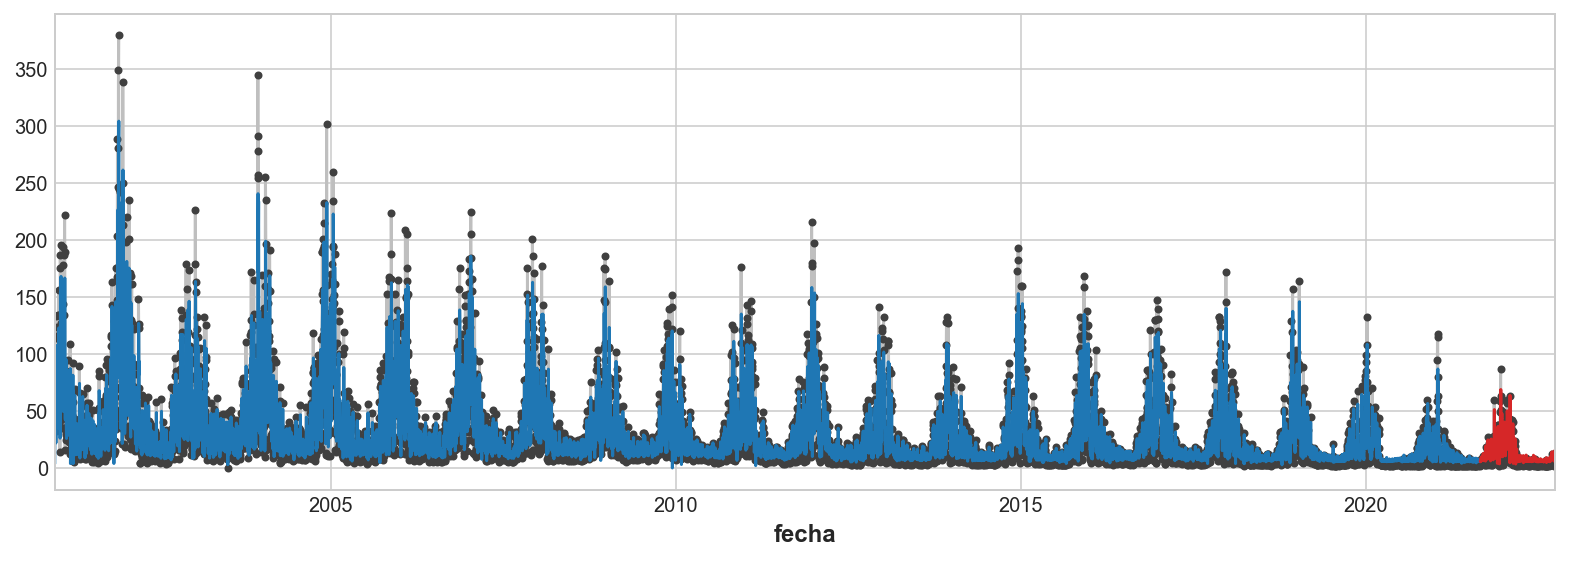

In [57]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')


Vamos a dibujar sólo las predicciones para visualizarlo más claramente.

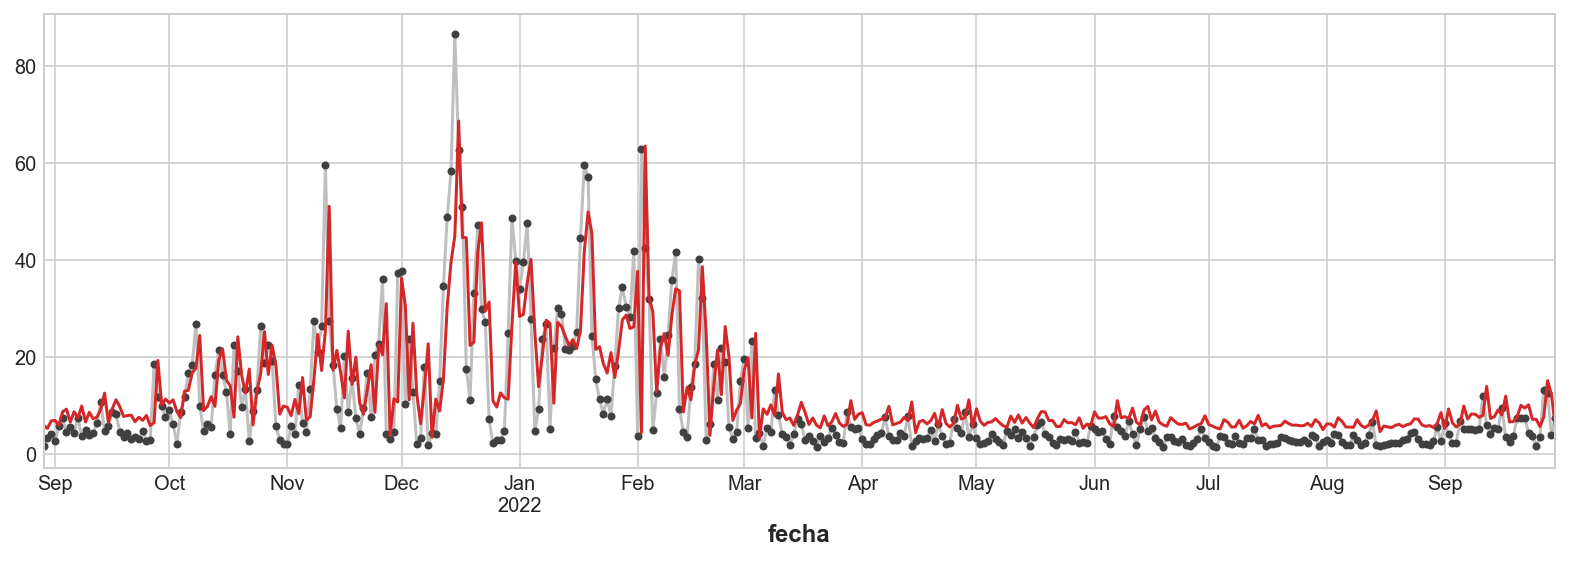

In [58]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Mirando solo los valores de predicción, podemos ver cómo nuestro modelo necesita un paso de tiempo para reaccionar a cambios repentinos en la serie objetivo. Esta es una limitación común de los modelos que usan solo lag’s de la serie objetivo como features.

Para mejorar la predicción, podríamos intentar encontrar *indicadores adelantados* (*leading indicators*), es decir, series temporales que pudieran proporcionar una “alerta temprana” para cambios en la medición del NO<sup>2</sup>. Estos indicadores podrían ser factores climáticos (previsión de lluvia, temperatura, etc.), días festivos (se podría pensar que en los días festivos el tráfico es menos intenso y eso afectaría a la medición de NO<sup>2</sup>), etc.


## Componenes y residuos

Muchas series temporales se pueden describir con precisión mediante un modelo aditivo de solo estos tres componentes más algunos errores esencialmente impredecibles y completamente aleatorios.

`series = tendencia + estacionalidad + ciclos + error`

Cada uno de los términos de este modelo se podría denominar **componente** de la serie temporal.

Los **residuos** de un modelo son las diferencias entre el objetivo en el que se entrenó el modelo y las predicciones que hace el modelo; en otras palabras, la diferencia entre la curva real y la curva entrenada. Si dibujamos los residuos contra una feature, obtendremos la parte “sobrante” del objetivo o lo que el modelo no pudo aprender sobre el objetivo a partir de esa feature. Los residuos contienen todo lo que el modelo de tendencia-estacionalidad no aprendió.

Podríamos imaginar aprender los componentes de una serie temporal como un proceso iterativo: primero se aprende la tendencia y se resta de la serie, luego se aprende la estacionalidad a partir de los residuos sin tendencia y se resta la estacionalidad, después se aprenden los ciclos y se restan los ciclos y, finalmente, solo queda el error impredecible.

Hasta ahora hemos usado un único algoritmo (regresión lineal) para aprender todos los componentes a la vez. Pero también es posible usar un algoritmo para unos componentes y otro algoritmo para el resto. De esta forma, siempre podemos elegir el mejor algoritmo para cada componente. Para hacer esto, usaremos un algoritmo para entrenar la serie original y después un segundo algoritmo para entrenar las series residuales.

En nuestro caso, usaremos regresión lineal para extrapolar la tendencia, trasformaremos el objetivo para eliminar la tendencia y aplicaremos XGBoost a los residuos sin tendencia. 

In [90]:
diario_no2 = pd.read_csv("diario_no2.cvs", sep=";", parse_dates=["fecha"])
diario_no2.set_index("fecha", inplace=True)
diario_no2 = diario_no2.asfreq('D')
diario_no2.sort_index(inplace=True)

In [91]:
diario_no2 = diario_no2.fillna(0.0)

In [92]:
dp = DeterministicProcess(
    index=diario_no2.index,  # fechas de los datos de entrenamiento
    constant=True,       # variable dummy para el bias (y_intercept)
    order=1,             # la time dummy (tendencia)
    drop=True,           # elimina términos si es necesario para evitar colinearidad
)
# crea features para las fechas dadas en el argumento `index`
X = dp.in_sample()

X.head()

,const,trend
fecha,,
2001-01-01,1.0,1.0
2001-01-02,1.0,2.0
2001-01-03,1.0,3.0
2001-01-04,1.0,4.0
2001-01-05,1.0,5.0


In [93]:
# Crea la serie objetivo y divide los datos
y = diario_no2.copy()


idx_train, idx_test = train_test_split(
    y.index, test_size=0.10, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Entrena y predice
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)


LinearRegression(fit_intercept=False)

In [94]:
# Hace predicciones
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

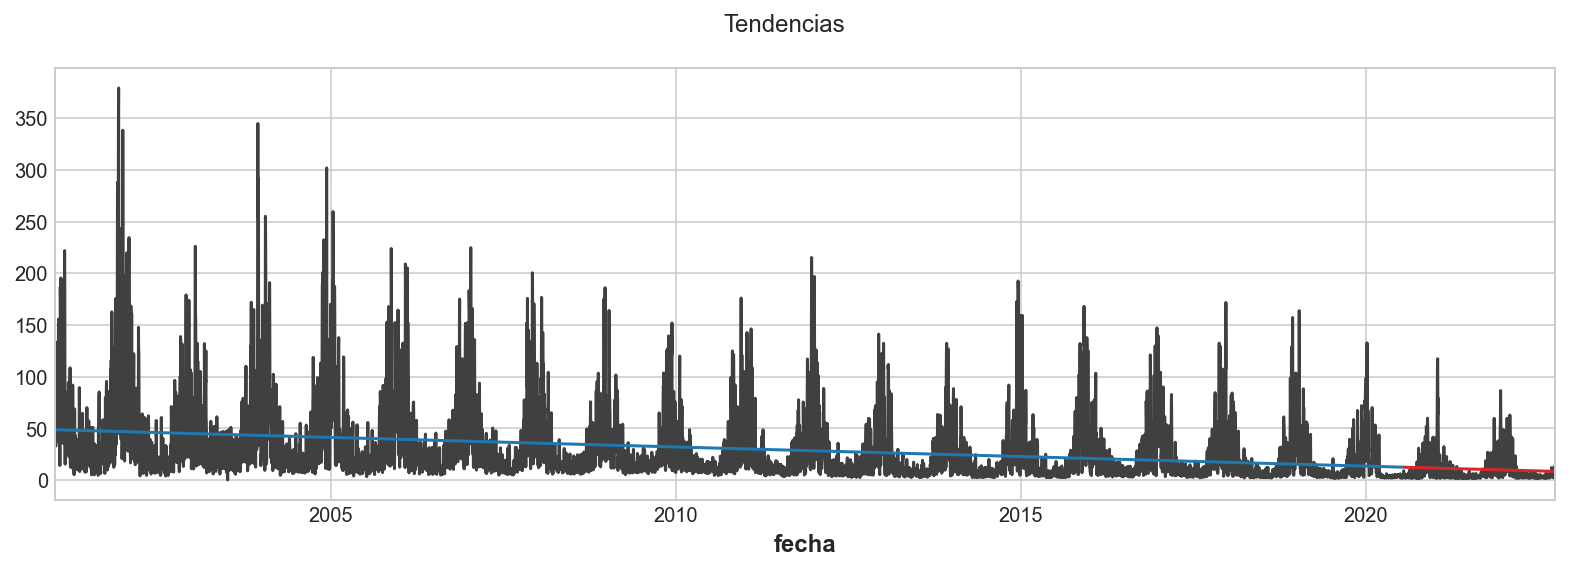

In [95]:
# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Tendencias")

In [96]:
# Crea la serie objetivo y divide los datos
y = diario_no2.copy()

# Codifica la etiqueta para estacionalidad anual
diario_no2["Mes"] = diario_no2.index.month
X = diario_no2.drop(["medicion"], axis=1)


idx_train, idx_test = train_test_split(
    y.index, test_size=0.10, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [97]:
#y_fit = y_fit.squeeze()    # tendencia del conjunto de entrenamiento
#y_pred = y_pred.squeeze()  # tendencia del conjunto de prueba

# Crea residuos (la colección de series sin tendencia) del conjunto de entrenamiento
y_resid = y_train - y_fit

# Entrena XGBoost en los residuos
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [98]:

# Y añade los residuos predichos en las tendencias predichas
y_fit_boosted = xgb.predict(X_train) + y_fit.squeeze()
y_pred_boosted = xgb.predict(X_test) + y_pred.squeeze()

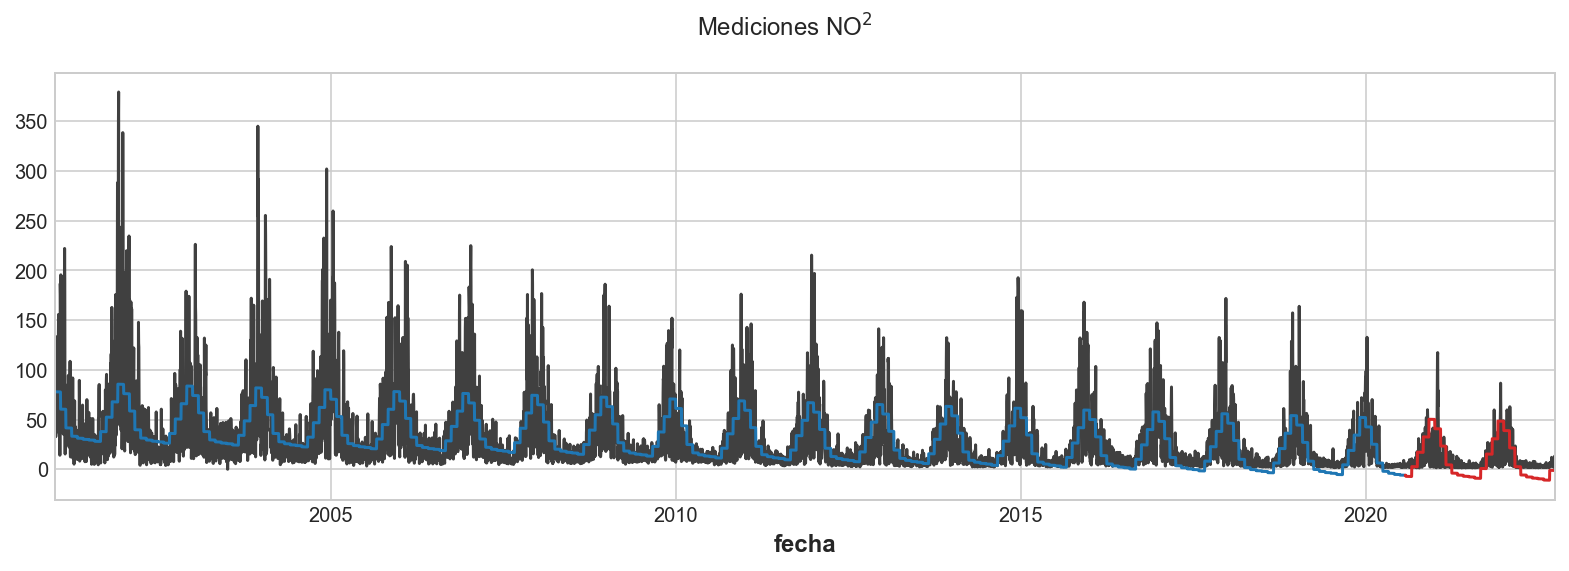

In [105]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit_boosted.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_boosted.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Mediciones NO$^2$")